## Facial keypoints detection

In this task you will create facial keypoint detector based on CNN regressor.


![title](example.png)

### Load and preprocess data

Script `get_data.py` unpacks data — images and labelled points. 6000 images are located in `images` folder and keypoint coordinates are in `gt.csv` file. Run the cell below to unpack data.

In [1]:
from get_data import unpack
unpack('facial-keypoints-data.zip')

ImportError: bad magic number in 'get_data': b'\x03\xf3\r\n'

Now you have to read `gt.csv` file and images from `images` dir. File `gt.csv` contains header and ground truth points for every image in `images` folder. It has 29 columns. First column is a filename and next 28 columns are `x` and `y` coordinates for 14 facepoints. We will make following preprocessing:
1. Scale all images to resolution $100 \times 100$ pixels.
2. Scale all coordinates to range $[-0.5; 0.5]$. To obtain that, divide all x's by width (or number of columns) of image, and divide all y's by height (or number of rows) of image and subtract 0.5 from all values.

Function `load_imgs_and_keypoint` should return a tuple of two numpy arrays: `imgs` of shape `(N, 100, 100, 3)`, where `N` is the number of images and `points` of shape `(N, 28)`.

In [1]:
### Useful routines for preparing data
from numpy import array, zeros
from os.path import join
from skimage.color import gray2rgb
from skimage.io import imread
from skimage.transform import resize
import pandas as pd

def load_imgs_and_keypoints(dirname='facial-keypoints'):
    df = pd.read_csv("data/gt.csv")
    all_rows = list(df.iterrows())
    imgs, points = [], []
    for index, row in all_rows:
        img = imread("data/images/"+row["filename"])
        img = gray2rgb(img)
        [old_height, old_width] = img.shape[0], img.shape[1]
        img = resize(img, (100, 100), anti_aliasing=True)
        [height, width] = img.shape[0], img.shape[1]
        point = row.values[1:]
        for i in range(0,len(point),2):
            point[i] = (point[i]/old_width)-0.5
            point[i+1] = (point[i+1]/old_height)-0.5
        imgs.append(img)
        points.append(point)
    return imgs, points
imgs, points = load_imgs_and_keypoints()

c:\users\matcha.11\appdata\local\continuum\anaconda3\envs\tf_gpu\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


array([-0.2765957446808511, -0.2872340425531915, -0.11702127659574468,
       -0.30851063829787234, 0.1063829787234043, -0.2978723404255319,
       0.35106382978723405, -0.23404255319148937, -0.25531914893617025,
       -0.21276595744680848, -0.1382978723404255, -0.22340425531914893,
       -0.07446808510638298, -0.2021276595744681, 0.12765957446808507,
       -0.18085106382978722, 0.22340425531914898, -0.18085106382978722,
       0.32978723404255317, -0.14893617021276595, -0.04255319148936171,
       -0.010638297872340441, -0.17021276595744683, 0.14893617021276595,
       -0.021276595744680826, 0.2021276595744681, 0.13829787234042556,
       0.19148936170212771], dtype=object)

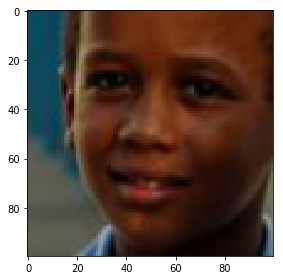

In [2]:
# Example of output
%matplotlib inline
from skimage.io import imshow
imshow(imgs[1])
points[1]

### Visualize data

Let's prepare a function to visualize points on image. Such function obtains two arguments: an image and a vector of points' coordinates and draws points on image (just like first image in this notebook).

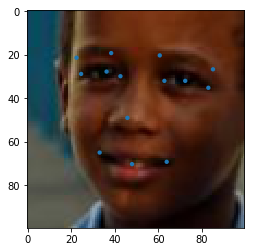

In [3]:
import matplotlib.pyplot as plt
# Circle may be useful for drawing points on face
# See matplotlib documentation for more info
from matplotlib.patches import Circle

def visualize_points(img, points):
    # Write here function which obtains image and normalized
    # coordinates and visualizes points on image
    fig,ax = plt.subplots(1)
    ax.set_aspect('equal')
    ax.imshow(img)
    for i in range(0,len(points),2):
       x, y = (points[i]+0.5)*img.shape[0], (points[i+1]+0.5)*img.shape[1]
       circ = Circle((x,y),1)
       ax.add_patch(circ)
    plt.show()
    
visualize_points(imgs[1], points[1])

### Train/val split

Run the following code to obtain train/validation split for training neural network.

In [4]:
from sklearn.model_selection import train_test_split
imgs_train, imgs_val, points_train, points_val = train_test_split(imgs, points, test_size=0.1)

### Simple data augmentation

For better training we will use simple data augmentation — flipping an image and points. Implement function flip_img which flips an image and its' points. Make sure that points are flipped correctly! For instance, points on right eye now should be points on left eye (i.e. you have to mirror coordinates and swap corresponding points on the left and right sides of the face). VIsualize an example of original and flipped image.

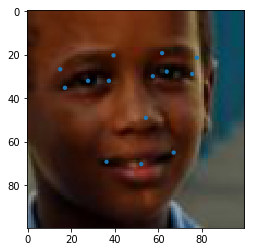

In [5]:
import numpy as np
def flip_img(img, points):
    # Write your code for flipping here
    img = np.fliplr(img)
    for i in range(0, len(points), 2):
        points[i] = -points[i]
    return img, points

f_img, f_points = flip_img(imgs[1], points[1])
visualize_points(f_img, f_points)

Time to augment our training sample. Apply flip to every image in training sample. As a result you should obtain two arrays: `aug_imgs_train` and `aug_points_train` which contain original images and points along with flipped ones.

In [6]:
aug_imgs_train = []
aug_points_train = []
for i in range(len(imgs_train)):
    img, point = flip_img(imgs_train[i], points_train[i])
    aug_imgs_train.append(imgs_train[i])
    aug_points_train.append(points_train[i])
    aug_imgs_train.append(img)
    aug_points_train.append(point)

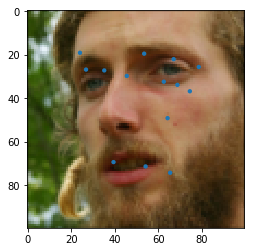

In [7]:
visualize_points(aug_imgs_train[2], aug_points_train[2])

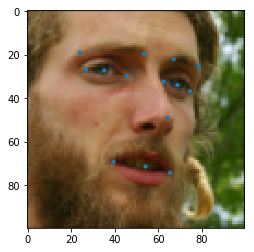

In [8]:
visualize_points(aug_imgs_train[3], aug_points_train[3])

### Network architecture and training

Now let's define neural network regressor. It will have 28 outputs, 2 numbers per point. The precise architecture is up to you. We recommend to add 2-3 (`Conv2D` + `MaxPooling2D`) pairs, then `Flatten` and 2-3 `Dense` layers. Don't forget about ReLU activations. We also recommend to add `Dropout` to every `Dense` layer (with p from 0.2 to 0.5) to prevent overfitting.


In [12]:
import tensorflow as tf
from keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten,
    Dense, Dropout, Input
)
image_input = Input(shape=(100, 100, 3), name='input_layer')
conv_1 = Conv2D(32,
                kernel_size=(3, 3),
                padding='same',
                activation='relu')(image_input)
conv_2 = Conv2D(64,
                kernel_size=(3, 3),
                padding='same',
                activation='relu')(conv_1)
conv_3 = Conv2D(64,
                kernel_size=(3, 3),
                padding='same',
                activation='relu')(conv_2)
pool_1 = MaxPooling2D()(conv_1)
conv_4 = Conv2D(32,
                kernel_size=(3, 3),
                padding='same',
                activation='relu')(pool_1)
conv_5 = Conv2D(32,
                kernel_size=(3, 3),
                padding='same',
                activation='relu')(conv_4)
conv_6 = Conv2D(32,
                kernel_size=(3, 3),
                padding='same',
                activation='relu')(conv_5)

# Flatten the output of the convolutional layers
conv_flat = Flatten()(conv_6)

# Some dense layers with two separate outputs
fc_1 = Dense(36, activation='relu')(conv_flat)
fc_1 = Dropout(0.2)(fc_1)
fc_2 = Dense(32, activation='relu')(fc_1)
fc_2 = Dropout(0.2)(fc_2)
output = Dense(28, name='keypoints')(fc_2)

# Wrap in a Model
model = tf.keras.Model(inputs=image_input, outputs=output)


In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     (None, 100, 100, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 100, 100, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 50, 50, 32)        9248      
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 50, 50, 32)        9248      
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 50, 50, 32)        9248      
_________________________________________________________________
flatten_1 (Flatten)          (None, 80000)             0         
__________

Time to train! Since we are training a regressor, make sure that you use mean squared error (mse) as loss. Feel free to experiment with optimization method (SGD, Adam, etc.) and its' parameters.

In [14]:
# ModelCheckpoint can be used for saving model during training.
# Saved models are useful for finetuning your model 
# See keras documentation for more info
from keras.callbacks import ModelCheckpoint
from keras.optimizers import SGD, Adam
model.compile(optimizer='adam', 
              loss='mse',
              metrics=['mse', 'mae'])
model.fit(np.array(aug_imgs_train), np.array(aug_points_train), epochs=10)

Epoch 1/10
10800/10800 [==============================] - 103s 10ms/step - loss: 0.0084 - mean_squared_error: 0.0084 - mean_absolute_error: 0.0643
Epoch 2/10
10800/10800 [==============================] - 61s 6ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - mean_absolute_error: 0.0412
Epoch 3/10
10800/10800 [==============================] - 61s 6ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - mean_absolute_error: 0.0386
Epoch 4/10
10800/10800 [==============================] - 60s 6ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - mean_absolute_error: 0.0374
Epoch 5/10
10800/10800 [==============================] - 61s 6ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - mean_absolute_error: 0.0366A: 46s - loss: 0.0029 - mean_squ
Epoch 6/10
10800/10800 [==============================] - 61s 6ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - mean_absolute_error: 0.0362
Epoch 7/10
10800/10800 [==============================] - 61s 6ms/step - loss: 0.0029 - mean_squ

### Visualize results

Now visualize neural network results on several images from validation sample. Make sure that your network outputs different points for images (i.e. it doesn't output some constant).

[[ 2.9189312e-01 -2.7513596e-01  1.0638643e-01 -2.8142563e-01
  -9.7915843e-02 -2.8217697e-01 -2.8822398e-01 -2.7942583e-01
   2.4853098e-01 -1.8832831e-01  1.7544590e-01 -1.9332796e-01
   1.1001009e-01 -1.8694483e-01 -1.1186197e-01 -1.8220414e-01
  -1.8270589e-01 -1.9020301e-01 -2.5547260e-01 -1.8860948e-01
   5.2596312e-03  2.3503089e-02  1.3202457e-01  1.9104142e-01
   1.3100408e-04  1.9697708e-01 -1.3389914e-01  1.8867394e-01]]


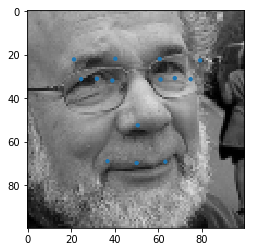

In [15]:
ind = 10
def check_test_image(ind):
    points_val = model.predict(np.array([imgs_val[ind]]))
    print(points_val)
    visualize_points(imgs_val[ind], points_val[0])
check_test_image(0)    

[[ 0.32267925 -0.23526931  0.15316892 -0.26074255 -0.03607761 -0.28781554
  -0.22550249 -0.31092808  0.274704   -0.15361491  0.2030303  -0.16310993
   0.135277   -0.16711055 -0.0625447  -0.20559967 -0.14683515 -0.22189844
  -0.2247626  -0.22647598  0.04308489  0.00542687  0.11662039  0.1924221
  -0.00174098  0.17822148 -0.13991599  0.14904216]]


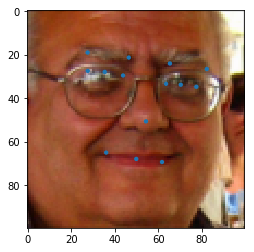

In [16]:
check_test_image(1)    